This is a jupyter notebook for the take-home challenge from Tencent NA.

A dateset is provided in a CSV file "topline_matrics.csv".\
The tasks accomplished are:
1. Clustering/prediction models based on the attached dataset.
2. Use Anomaly Detection methodologies to detect anomaly from the attached data.

Some foundings are included in the data visualization part.

# Index
* [Load and inpect data](#Load-and-inpect-data)
* [Outliers](#Outliers)
    * [Conversion](#Conversion)
    * [Time Spend Per Day](#Time-Spend-Per-Day)
* [Inspect Country's distribution](#Inspect-Country's-distribution)
* [Visualize data](#Visualize-data)
* [Cluster](#Cluster)
    * [Preprocessing](#Preprocessins)
    * [KMeans](#KMeans)
    * [DBSCAN](#DBSCAN)
* [Anomaly detection](#Anomaly-detection)
    * [KMeans clustering](#KMeans-Clustering)
    * [Isolation Forest](#Isolation-Forest)
    * [Support Vector Machine](#Support-Vector-Machine)
* [Summary](#Summary)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pickle
import re
matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'DejaVu Sans']
matplotlib.rcParams['figure.dpi'] = 400
%matplotlib inline
import warnings  # Ignore warnings poped out on some platforms when plotting
warnings.filterwarnings("ignore")

# Load sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

## Load and inpect data

In [4]:
# Read data
inputfilename = 'topline_metrics.csv'
df = pd.read_csv(inputfilename)
df.head(3)

,Date,Date.1,Platform,Country,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds)
0,2018-03-15,2018-03-15,Android(All),Kazakhstan(哈萨克斯坦),628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18
1,2018-03-15,2018-03-15,ALL,United States(美国),633293.54,19939.05,43429.11,3428.09,17.58,1.3,2.3,4527.01,75.65,58.87
2,2018-03-15,2018-03-15,Android(All),Kazakhstan(哈萨克斯坦),628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18


In [5]:
# Check if there is any empty cells
df.isnull().sum().sort_values(ascending=False)

Time Spend Per Day(seconds)    0
Return Customer                0
Cash Flow                      0
Conversion                     0
Items per DAU                  0
Items Per Trans                0
Trans                          0
Items                          0
DAU                            0
TRU                            0
Country                        0
Platform                       0
Date.1                         0
Date                           0
dtype: int64

There is no empty items in the dataset, so we don't need to manually fill or drop values.

In [6]:
# Glance at data
df.describe()

,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds)
count,7.482640e+05,7.482640e+05,7.482640e+05,748264.00000,748264.000000,748264.000000,748264.000000,748264.000000,748264.000000,748264.000000
mean,7.399568e+05,1.816949e+04,5.089120e+04,3958.49364,31.569433,1.414330,2.902036,5093.453512,39.795054,122.605716
std,6.776595e+05,1.801799e+04,4.610241e+04,3655.62504,23.629177,1.208879,2.591666,4712.790645,24.796009,43.331318
min,6.286478e+05,1.529217e+04,4.342911e+04,3428.09000,17.580000,1.300000,2.300000,4527.010000,12.210000,-9.990000
25%,6.288102e+05,1.529677e+04,4.342911e+04,3428.09000,17.580000,1.300000,2.300000,4527.010000,28.660000,98.950000
50%,6.314452e+05,1.537393e+04,4.352124e+04,3433.85000,28.090000,1.320000,2.560000,4532.770000,39.430000,118.180000
75%,6.574735e+05,1.617663e+04,4.466021e+04,3522.53000,36.080000,1.390000,3.000000,4611.080000,48.920000,139.370000
max,2.677675e+07,2.141935e+06,4.387412e+06,434846.58000,1744.870000,444.240000,232.630000,819825.280000,3912.090000,1390.060000


The column names have spaces, which can be annoying some times. The first two columns have the same names originally; the name of countries are mixed of Chinese characters and English letters; the last column has unit in its name, which is redundant when coding. I prefer to re-format them.

In [7]:
df['Date'].equals(df['Date.1'])

True

Since the first and the second column are identical, we can just keep one of them.

In [8]:
# Remove the second column,which is identical with the first column
df.drop('Date.1', axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])  # Time format

In [9]:
# Use regex to leave only Chinese characters in Country's name, as some
# countries do not have english name in the data set.
# Keep "Other" countries
df['Country'] = df['Country'].map(lambda x: re.search(r'[\u4e00-\u9fff]+|$', x).group())
df = df.replace('', '其他')

In [10]:
# Formatting the column names
df.rename(columns={'Time Spend Per Day(seconds)': 'Time Spend Per Day'}, inplace=True)  # Remove unit in the last row's name
df.columns = [c.replace(' ', '_') for c in df.columns]  # Replace space by underscore
df.head(3)

,Date,Platform,Country,TRU,DAU,Items,Trans,Items_Per_Trans,Items_per_DAU,Conversion,Cash_Flow,Return_Customer,Time_Spend_Per_Day
0,2018-03-15,Android(All),哈萨克斯坦,628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18
1,2018-03-15,ALL,美国,633293.54,19939.05,43429.11,3428.09,17.58,1.3,2.3,4527.01,75.65,58.87
2,2018-03-15,Android(All),哈萨克斯坦,628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18


### Outliers

There are some obvious abnormal data to be handled, for example the maximum conversion rate is over 100% and the minimum time spent per day is negative. We should first get rid of such data outliers.

#### Conversion

In [11]:
# Conversion should be smaller than 100
# Time Spent per day should be non-negative
df.loc[(df.Conversion>100) & (df.Time_Spend_Per_Day < 0), :]

,Date,Platform,Country,TRU,DAU,Items,Trans,Items_Per_Trans,Items_per_DAU,Conversion,Cash_Flow,Return_Customer,Time_Spend_Per_Day
524347,2019-08-07,IOS(All),图瓦卢,628647.81,15293.32,43440.62,3429.24,29.07,12.79,117.46,4528.17,12.21,-6.54
695006,2020-01-19,IOS(All),基里巴斯,628647.81,15293.32,43440.62,3429.24,29.08,12.80,117.46,4528.17,12.21,-8.27
695195,2020-01-19,IOS(All),基里巴斯,628647.81,15293.32,43440.62,3429.24,29.08,12.80,117.46,4528.17,12.21,-8.27


There are three rows with both abnormal **Conversion** and **Time_Spend_Per_Day**.

In [12]:
# Find abnormals
df.loc[(df.Conversion>100), :]

,Date,Platform,Country,TRU,DAU,Items,Trans,Items_Per_Trans,Items_per_DAU,Conversion,Cash_Flow,Return_Customer,Time_Spend_Per_Day
84426,2018-06-08,ALL,诺福克岛,628647.81,15292.17,43432.56,3429.24,21.47,5.19,117.46,4527.01,12.21,64.98
132352,2018-07-26,ALL,马恩岛,628647.81,15292.17,43444.08,3429.24,32.94,16.66,117.46,4528.17,12.21,69.47
132867,2018-07-26,ALL,马恩岛,628647.81,15292.17,43444.08,3429.24,32.94,16.66,117.46,4528.17,12.21,69.47
132993,2018-07-26,ALL,马恩岛,628647.81,15292.17,43444.08,3429.24,32.94,16.66,117.46,4528.17,12.21,69.47
161847,2018-08-23,Android(All),瓦利斯和富图纳,628647.81,15292.17,43486.69,3429.24,75.14,58.86,117.46,4531.62,12.21,712.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...
739584,2020-03-01,Android(All),根西岛,628647.81,15292.17,43436.02,3429.24,24.33,8.05,117.46,4527.01,12.21,25.48
742101,2020-03-04,Android(All),根西岛,628647.81,15292.17,43430.26,3429.24,18.33,2.05,117.46,4527.01,12.21,84.67
742213,2020-03-04,Android(All),朝鲜,628647.81,15292.17,43434.87,3429.24,23.20,6.92,117.46,4527.01,12.21,272.50
742362,2020-03-04,Android(All),根西岛,628647.81,15292.17,43430.26,3429.24,18.33,2.05,117.46,4527.01,12.21,84.67


There are 242 outliers in terms of conversion rate, which for some reason all share some identical features, including **TRU**, **DAU**, **Trans**, **Conversion** and **Return Custom**. 

In [13]:
df.loc[df.Conversion<=100, :].describe()

,TRU,DAU,Items,Trans,Items_Per_Trans,Items_per_DAU,Conversion,Cash_Flow,Return_Customer,Time_Spend_Per_Day
count,7.480220e+05,7.480220e+05,7.480220e+05,748022.000000,748022.000000,748022.000000,748022.000000,748022.000000,748022.000000,748022.000000
mean,7.399928e+05,1.817042e+04,5.089360e+04,3958.664854,31.565888,1.406276,2.864359,5093.636245,39.803978,122.572361
std,6.777662e+05,1.802083e+04,4.610967e+04,3656.203931,23.610861,0.505054,1.503238,4713.541972,24.795055,43.166742
min,6.286478e+05,1.529217e+04,4.342911e+04,3428.090000,17.580000,1.300000,2.300000,4527.010000,12.210000,-9.990000
25%,6.288113e+05,1.529677e+04,4.342911e+04,3428.090000,17.580000,1.300000,2.300000,4527.010000,28.660000,98.950000
50%,6.314521e+05,1.537393e+04,4.352124e+04,3433.850000,28.090000,1.320000,2.560000,4532.770000,39.430000,118.180000
75%,6.574962e+05,1.617778e+04,4.466137e+04,3522.530000,36.080000,1.390000,3.000000,4611.080000,48.920000,139.370000
max,2.677675e+07,2.141935e+06,4.387412e+06,434846.580000,1744.870000,73.470000,59.880000,819825.280000,3912.090000,1390.060000


Wihtout the outliers of **Conversion**, there are 748022 rows of data with the range of **Conversion** from 2.3 to 59.88, which is more reasonable, though the maximum value is significantly larger than even the 75% percentile.

The outliers only account for 0.03234% of the total dataset and they all come from small countres that are less populated and less developed. We have a very good reason to surmise that the data sources in these countries are not pretty reliable, therefore we should ignore these data.

In [14]:
# Remove abnormals
df = df.loc[df.Conversion<=100, :]

#### Time Spend Per Day

In [15]:
df.loc[df.Time_Spend_Per_Day<0, :]

,Date,Platform,Country,TRU,DAU,Items,Trans,Items_Per_Trans,Items_per_DAU,Conversion,Cash_Flow,Return_Customer,Time_Spend_Per_Day
93,2018-03-15,ALL,巴哈马,628647.81,15293.32,43429.11,3428.09,17.58,1.3,2.3,4527.01,12.21,-9.99
158,2018-03-15,Android(All),巴哈马,628647.81,15293.32,43429.11,3428.09,17.58,1.3,2.3,4527.01,12.21,-9.99
160,2018-03-15,ALL,安道尔,628648.96,15294.47,43429.11,3428.09,17.58,1.3,2.3,4527.01,12.21,-2.74
169,2018-03-15,Android(All),巴哈马,628647.81,15293.32,43429.11,3428.09,17.58,1.3,2.3,4527.01,12.21,-9.99
181,2018-03-15,ALL,格林纳达,628647.81,15293.32,43429.11,3428.09,17.58,1.3,2.3,4527.01,12.21,-8.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
747030,2020-03-08,IOS(All),英属印度洋领地,628647.81,15292.17,43429.11,3428.09,17.58,1.3,2.3,4527.01,12.21,-1.93
747117,2020-03-08,IOS(All),英属印度洋领地,628647.81,15292.17,43429.11,3428.09,17.58,1.3,2.3,4527.01,12.21,-1.93
747475,2020-03-09,IOS(All),基里巴斯,628647.81,15292.17,43429.11,3428.09,17.58,1.3,2.3,4527.01,12.21,-9.19
747810,2020-03-09,IOS(All),基里巴斯,628647.81,15292.17,43429.11,3428.09,17.58,1.3,2.3,4527.01,12.21,-9.19


Just like what we saw above, the rest 1032 (0.138%) outliers with negative **Time_Spend_Per_Day** somehow share identical information in other columns. Again the data source is probably not reliable due to the same reason, and we choose to remove them.

In [16]:
df = df.loc[df.Time_Spend_Per_Day>=0, :]
df.describe()

,TRU,DAU,Items,Trans,Items_Per_Trans,Items_per_DAU,Conversion,Cash_Flow,Return_Customer,Time_Spend_Per_Day
count,7.469900e+05,7.469900e+05,7.469900e+05,746990.000000,746990.000000,746990.000000,746990.000000,746990.000000,746990.000000,746990.000000
mean,7.401413e+05,1.817318e+04,5.090383e+04,3959.386961,31.584992,1.406380,2.864980,5094.417427,39.839095,122.749071
std,6.782207e+05,1.802984e+04,4.614068e+04,3658.675812,23.621483,0.504734,1.501235,4716.749912,24.788552,42.933628
min,6.286478e+05,1.529217e+04,4.342911e+04,3428.090000,17.580000,1.300000,2.300000,4527.010000,12.210000,0.030000
25%,6.288125e+05,1.529792e+04,4.342911e+04,3428.090000,17.580000,1.300000,2.300000,4527.010000,28.710000,98.950000
50%,6.314843e+05,1.537508e+04,4.352239e+04,3433.850000,28.100000,1.320000,2.570000,4532.770000,39.450000,118.300000
75%,6.575748e+05,1.618008e+04,4.466712e+04,3522.530000,36.110000,1.390000,3.000000,4611.080000,48.940000,139.490000
max,2.677675e+07,2.141935e+06,4.387412e+06,434846.580000,1744.870000,73.470000,59.880000,819825.280000,3912.090000,1390.060000


## Visualize data

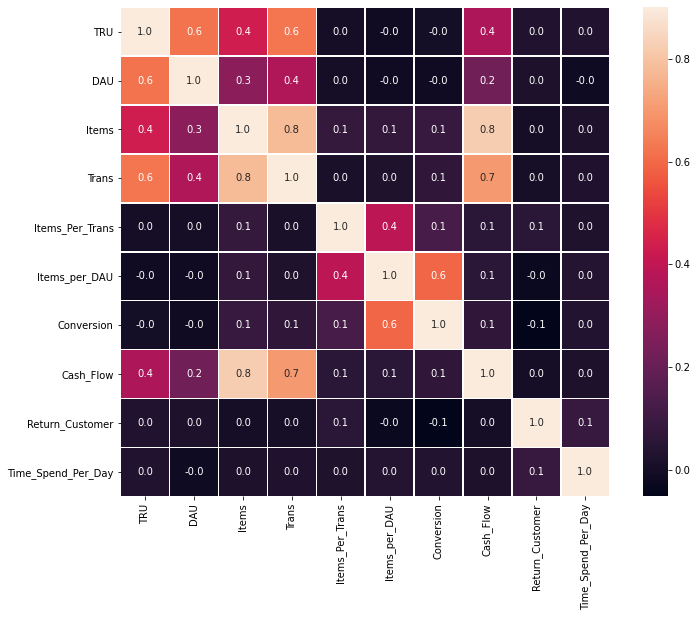

In [255]:
# Covariance between columns, except Date / Platform / Country
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(df.corr(), annot=True, fmt='.1f', linewidths=.5, vmax=0.9, square=True)

There is little correlation between most metircs.

<Figure size 432x288 with 0 Axes>

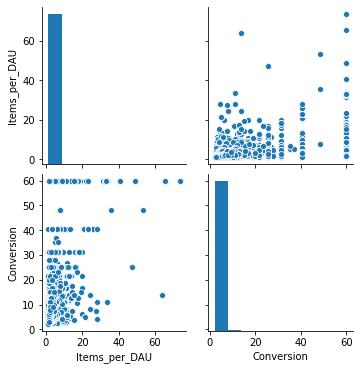

In [275]:
# Plot the metircs with high covariance
figure=plt.figure()
sns.pairplot(x_vars=['Items_per_DAU','Conversion'],y_vars=['Items_per_DAU','Conversion'],data=df,dropna=True)
plt.show()

There is some correlation between **Items_per_DAU** and **Conversion**. It is noticeble the upper bound of **Items_Per_DAU** seems increase with **Conversion**; while at certain **Conversion** rate, the **Items_per_DAU** can vary down to near zero values.

<Figure size 432x288 with 0 Axes>

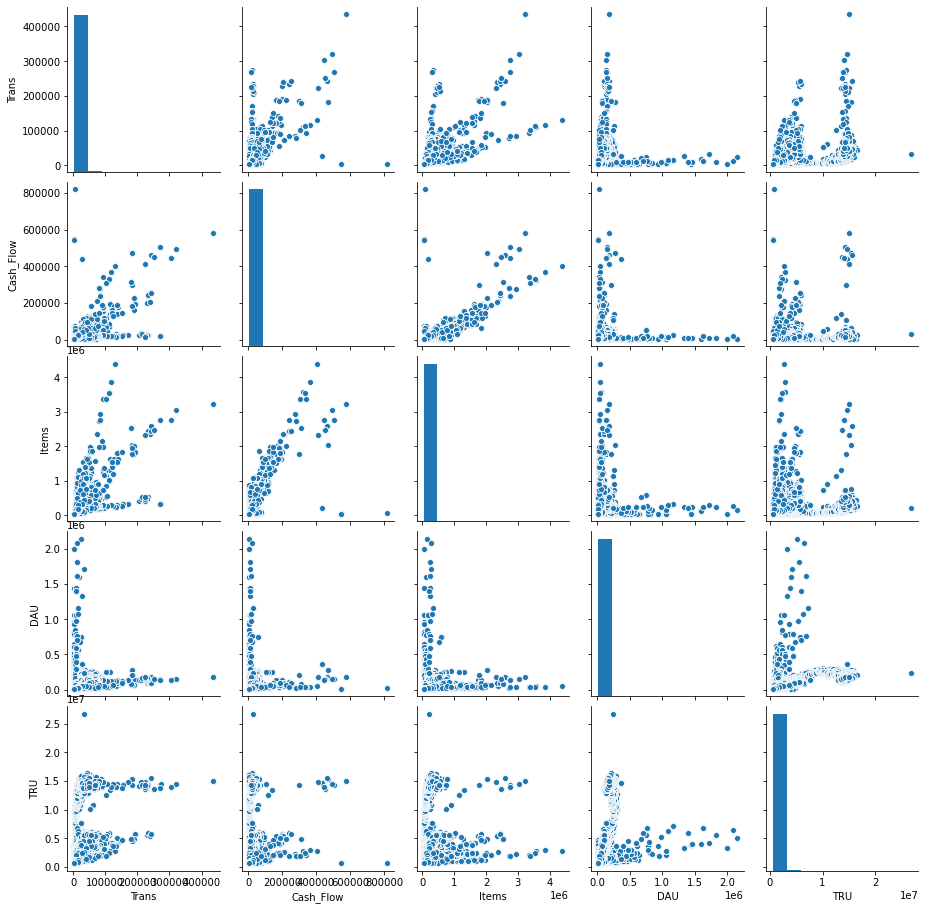

In [272]:
# Plot the metircs with high covariance
figure=plt.figure()
sns.pairplot(x_vars=['Trans','Cash_Flow','Items', 'DAU', 'TRU'],
             y_vars=['Trans','Cash_Flow','Items', 'DAU', 'TRU'],
             data=df, dropna=True)
plt.show()

**TRU** has two peaks but shows no clear trand with other metrics. **Items**, **Trans** and **Cash_Flow** shows some positive relation, which is fairly reasonalbe. The three slopes existing in some figures, e.g. **Trans** v.s. **Cash_Flow**, suggests the influence of the **Platform**, as can be seen below.

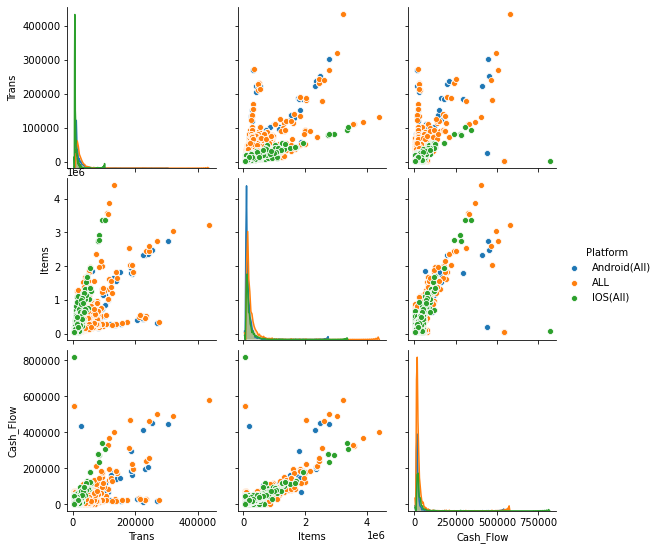

In [285]:
sns.pairplot(df.loc[:, ['Platform', 'Trans', 'Items', 'Cash_Flow']], hue="Platform", height=2.5)

It seems IOS users tends to purchase more items per transaction, which has little effects from exsiting credits in their accounts. However, among the users with the same amount of transactions, the IOS users  normally own higher credits.

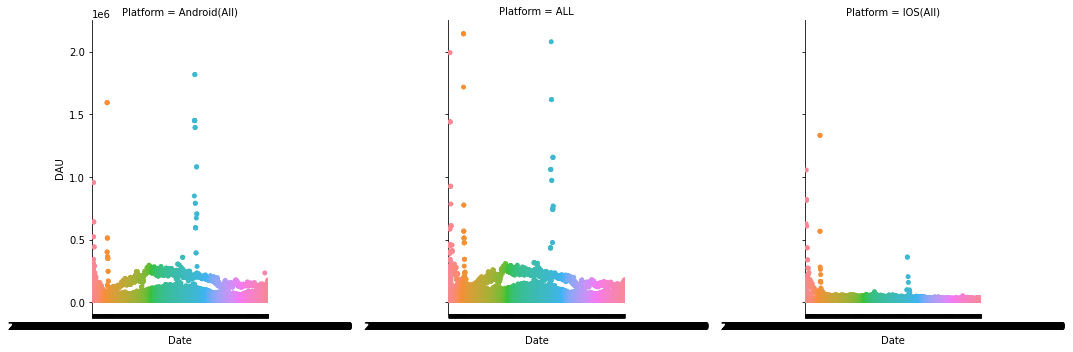

In [261]:
sns.catplot(x="Date", y="DAU", col="Platform", data=df)

The **DAU** metric shows some variation in the initial time and a spike around 2019/5, which are probably caused by promotion activities. Especially, the **DAU** on the IOS platform is relatively invariant, though with slightly decreasing trend.

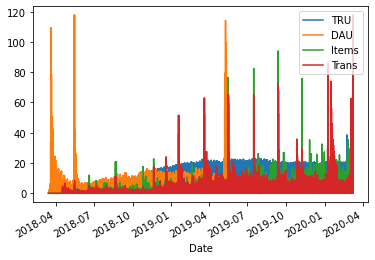

In [270]:
X = StandardScaler().fit_transform(df.iloc[:, 3:])
X = pd.DataFrame(X, columns=df.columns[3:])
X['Date'] = df['Date']
X.plot(x='Date', y=['TRU', 'DAU', 'Items', 'Trans'])

The **DAU** has three peaks in the first few months and 2019/5, implying new users stimulated to register. Since 2019 there is a periodic increase in some metrics including **DAU**, **Items**, **Trans** shown here, which is likely due to the promotions. However, the amount of items stops increase in the later stage in spite of the continuously climbing number of transactions. It depends on what the exact promotion is for further analysis.

([], <a list of 0 Text major ticklabel objects>)

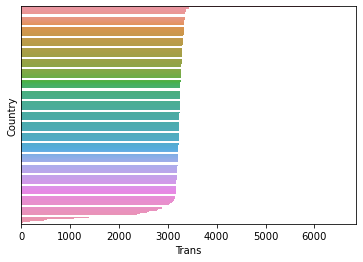

In [277]:
# Sum of Transactions at each country
country_trans = pd.crosstab(df.Country, df.Trans)
country_trans_total = country_trans.sum(axis=1).sort_values(ascending=False)
sns.barplot(y = country_trans_total.index, x = country_trans_total.values, orient='h')
plt.ylabel('Country')
plt.xlabel('Trans')
plt.yticks([])

The transactions from most countries are pretty close, likely indicating a wide acceptance of the product. 

## Cluster

### Preprocessing

In [18]:
# One-hot encoding "Platform" and "Country"
# Delete the redundant "ALL" platform and "Other" country
df = pd.get_dummies(df, columns=['Platform', 'Country'], prefix="", prefix_sep="")
del df['ALL']
del df['其他']

# Add a column of data converted to integers, for easier plotting
df['Date_Int'] = df.Date.astype(np.int64)

In [19]:
# Take useful features and standardize them.
# The Country feature is discarded, since by removing abnormals the 
# rest countries are assumed to be reliable source input.

scaled_data = StandardScaler().fit_transform(df.iloc[:, 1:13])
data_featured = pd.DataFrame(scaled_data)
data_featured.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,7.469900e+05,7.469900e+05,7.469900e+05,7.469900e+05,7.469900e+05,7.469900e+05,7.469900e+05,7.469900e+05,7.469900e+05,7.469900e+05,7.469900e+05,7.469900e+05
mean,-3.673538e-15,1.194569e-14,-1.850348e-14,8.590359e-14,2.865884e-13,-2.094402e-13,2.961263e-13,-1.480976e-13,9.212210e-14,-9.913903e-15,9.096070e-15,2.952321e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.643913e-01,-1.597912e-01,-1.619986e-01,-1.452157e-01,-5.928926e-01,-2.107655e-01,-3.763438e-01,-1.202964e-01,-1.114592e+00,-2.858346e+00,-7.096521e-01,-6.995172e-01
25%,-1.641485e-01,-1.594723e-01,-1.619986e-01,-1.452157e-01,-5.928926e-01,-2.107655e-01,-3.763438e-01,-1.202964e-01,-4.489614e-01,-5.543228e-01,-7.096521e-01,-6.995172e-01
50%,-1.602090e-01,-1.551927e-01,-1.599769e-01,-1.436414e-01,-1.475350e-01,-1.711406e-01,-1.964917e-01,-1.190752e-01,-1.569659e-02,-1.036268e-01,-7.096521e-01,-6.995172e-01
75%,-1.217400e-01,-1.105445e-01,-1.351674e-01,-1.194031e-01,1.915634e-01,-3.245368e-02,8.993943e-02,-1.024726e-01,3.671417e-01,3.899261e-01,1.409141e+00,1.429557e+00
max,3.838961e+01,1.177916e+02,9.398454e+01,1.177714e+02,7.253085e+01,1.427755e+02,3.797878e+01,1.727315e+02,1.562114e+02,2.951793e+01,1.409141e+00,1.429557e+00


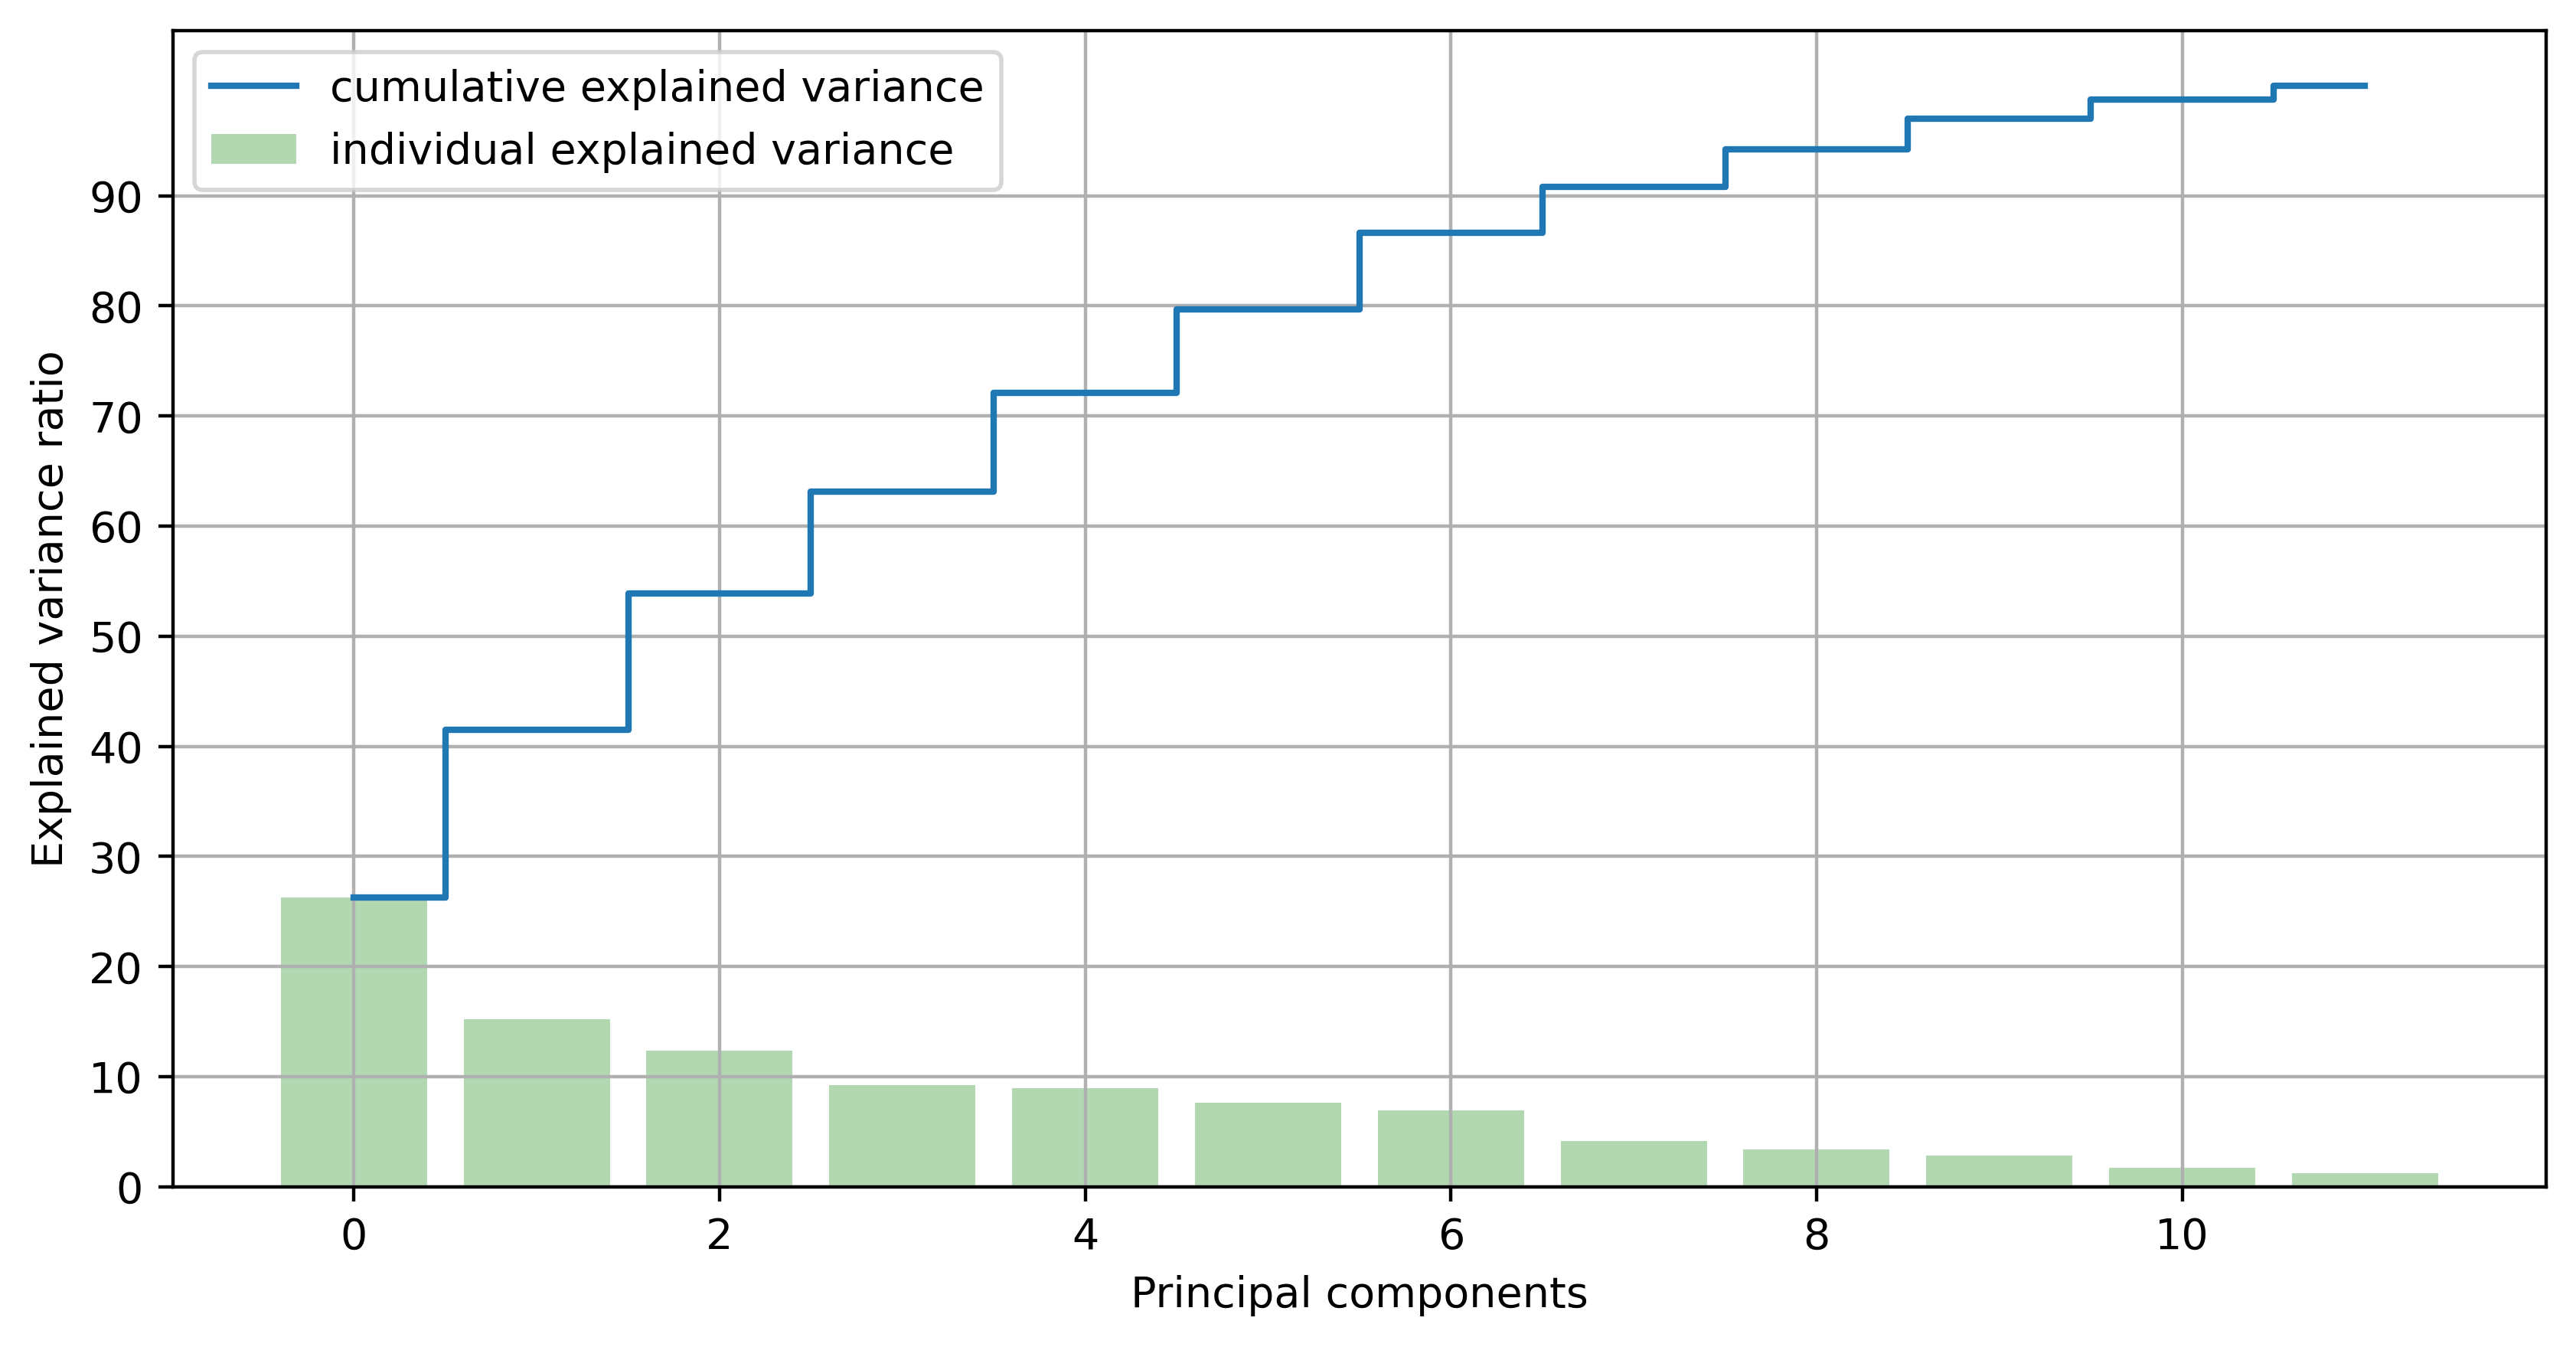

In [20]:
#Calculating Eigenvecors and eigenvalues of Covariance matrix

mean_vec = np.mean(data_featured, axis=0)
cov_mat = np.cov(data_featured.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Create a list of (eigenvalue, eigenvector) tuples, sort by engenvalues
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

# Visualize explained variance
plt.figure(figsize=(10, 5), dpi=400)
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.yticks(range(0, 100, 10))
plt.legend(loc='best')
plt.grid('on')
plt.show()

We see the first six components explain about 80% of the variance and first eight explain 90%. We can set number of components to 8.

In [21]:
# Reduced to 8 important components
n_comp = 8
pca = PCA(n_components=n_comp)
data_tmp = pca.fit_transform(data_featured)
# Standardize the 8 features
scaled_data = StandardScaler().fit_transform(data_tmp)
data_PCA = pd.DataFrame(scaled_data)
data_PCA.head()

# Add principle components
df.index = data_PCA.index
for i in range(n_comp):
    df[f'PC_{i}'] = data_PCA[i]

### KMeans

[Text(0, 0.5, 'Score'),
 Text(0.5, 0, 'Number of Clusters'),
 Text(0.5, 1.0, 'Elbow Curve')]

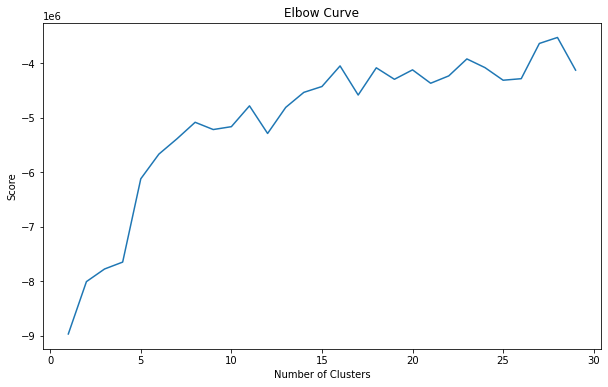

In [150]:
# Use elbow curve to determine number of clusters

n_cluster = range(1, 30)  # at most 30 clusters
models = []
for i in n_cluster:
    models.append(MiniBatchKMeans(n_clusters=i, batch_size=64).fit(data_featured))
scores = [models[i].score(data_featured) for i in range(len(models))]

# Visualize the elbow curve to pick number of clusters
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
ax.set(xlabel='Number of Clusters', ylabel='Score', title='Elbow Curve')

Thr curve levels off after about 20 clusters, implying adding more clusters will not explain much more of the variance in our relevant variables. 

In [ ]:
# Cluster using KMeans

# Train the KMeans model with 20 clusters using MiniBatchKMeans to speed up
cluster_KMeans = MiniBatchKMeans(n_clusters=20, batch_size=64).fit(data)

# Predict cluster numbers
df['cluster_KMeans'] = cluster_KMeans.predict(data_PCA)

# Show count of each cluster
print("Cluster", "Count")
df['cluster_KMeans'].value_counts()

### DBSCAN

In [ ]:
# Cluster using DBSCAN

from sklearn.neighbors import NearestNeighbors

# Pre-compute neighborhoods
neigh = NearestNeighbors(radius=0.5, metric='cosine').fit(data_PCA)
data_neigh = neigh.radius_neighbors_graph(mode='distance')

# Create DBSCAN object
cluster = DBSCAN(n_jobs=-1, metric='precomputed')

# Train model
cluster_DBSCAN = cluster.fit(data_neigh)

# Predict
df['cluster_DBSCAN'] = cluster_DBSCAN.predict(data_PCA)

# Count of each cluster
print("Cluster", "Count")
df['cluster_DBSCAN'].value_counts()

## Anomaly detection

Contamination depicts the proportion proportion of outliers in the dataset. This value varies for different case. Here it is set to be 0.005 / 0.5% below, which is in the same scale of the abnormals removed above.

In [292]:
# Assume 0.5% anomaly
contamination = 0.005  

# A helper function for plotting
def plot_anomaly(col_anomaly, metric):
    """Plot anomaly in terms of metric
    
    Parameters
    ----------
    col_anomaly : str
        The column recording if anomaly or not
    metric : str
        The metric relevant to the shown anomaly 
    """
    fig, ax = plt.subplots(dpi=400)
    anomaly = df.loc[df[col_anomaly] == -1, ['Date_Int', metric]]  # anomaly

    ax.plot(df['Date_Int'], df[metric], color='blue', label='Inlier')
    ax.scatter(anomaly['Date_Int'],anomaly[metric], color='red',
               label='Outlier')
    plt.xlabel('Date Time Integer')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    return

### KMeans clustering

After being clustered, normal data will belong to larger clusters while anomalies will not belong to any clusters or belong to small clusters.

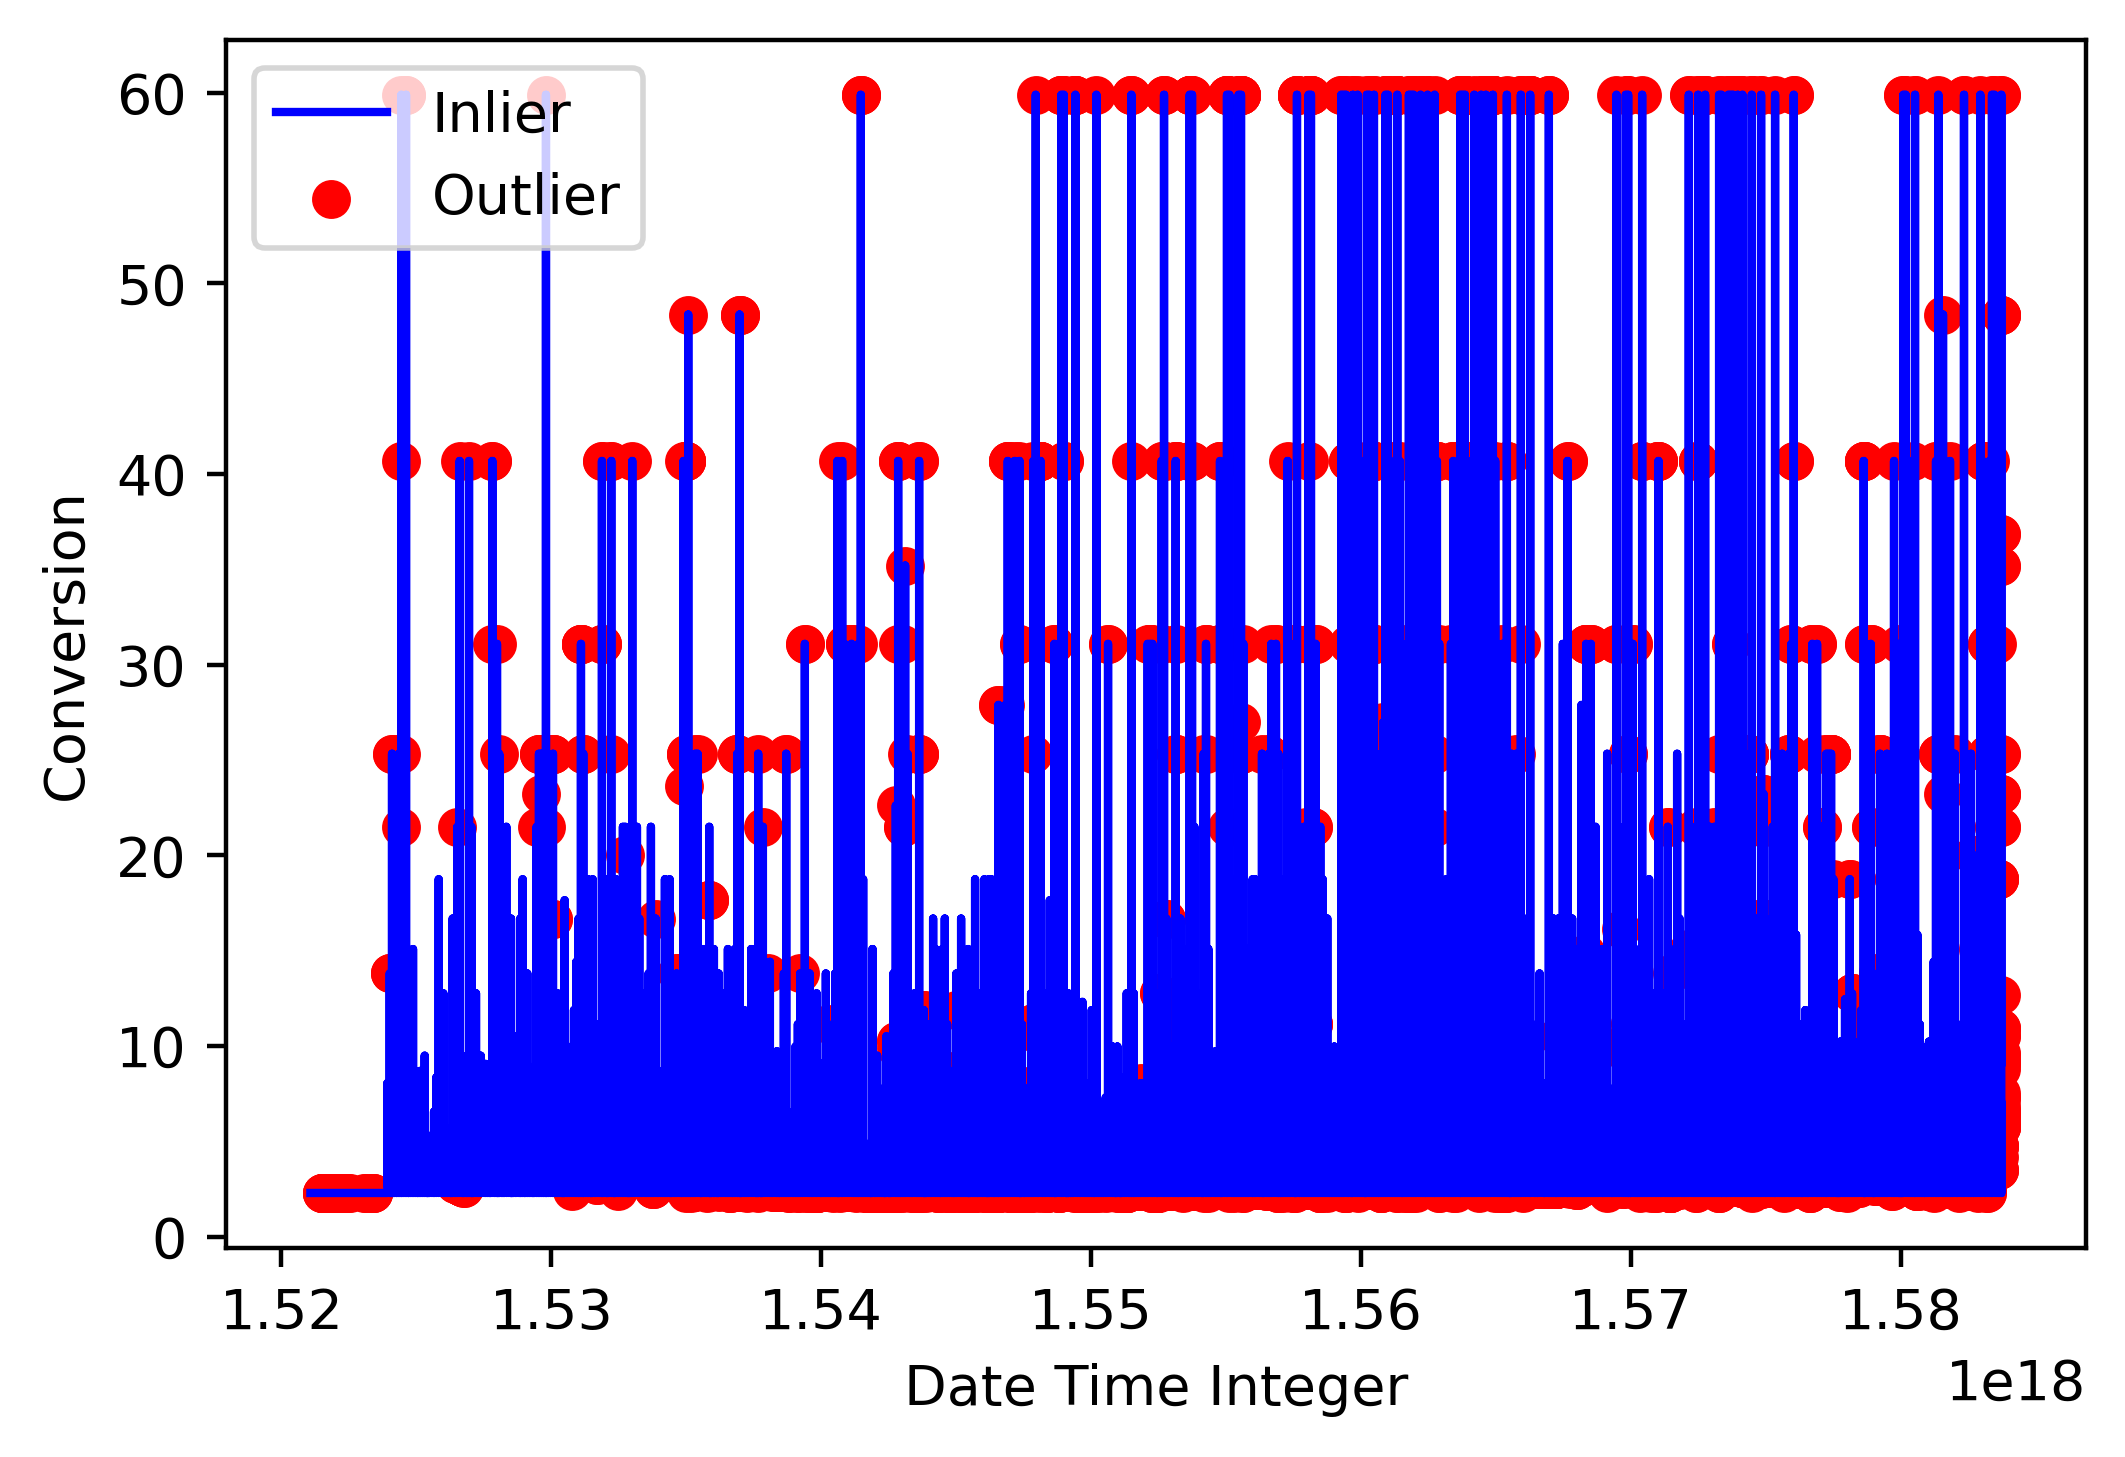

In [294]:
# Compute distance between each point and its nearest centroid
def get_distance_by_point(data, model):
    distance = np.zeros(len(data))
    for i in range(len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        distance[i] = np.linalg.norm(Xa - Xb)
    return pd.Series(distance)

# Points with the largest distances are considered anomalies
distance = get_distance_by_point(data_PCA, cluster_KMeans)
n_outliers = int(contamination * len(distance))
threshold = distance.nlargest(n_outliers).min()

# The column "anomaly_KMeans" contains the anomaly result of the above
# method (0:normal, 1:anomaly) 
df['anomaly_KMeans'] = -(distance >= threshold).astype(int)

# Visulize the outliers in terms of the metric
metric = 'Conversion'
plot_anomaly('anomaly_KMeans', metric)

### Isolation Forest

The IsolationForest "isolates" observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

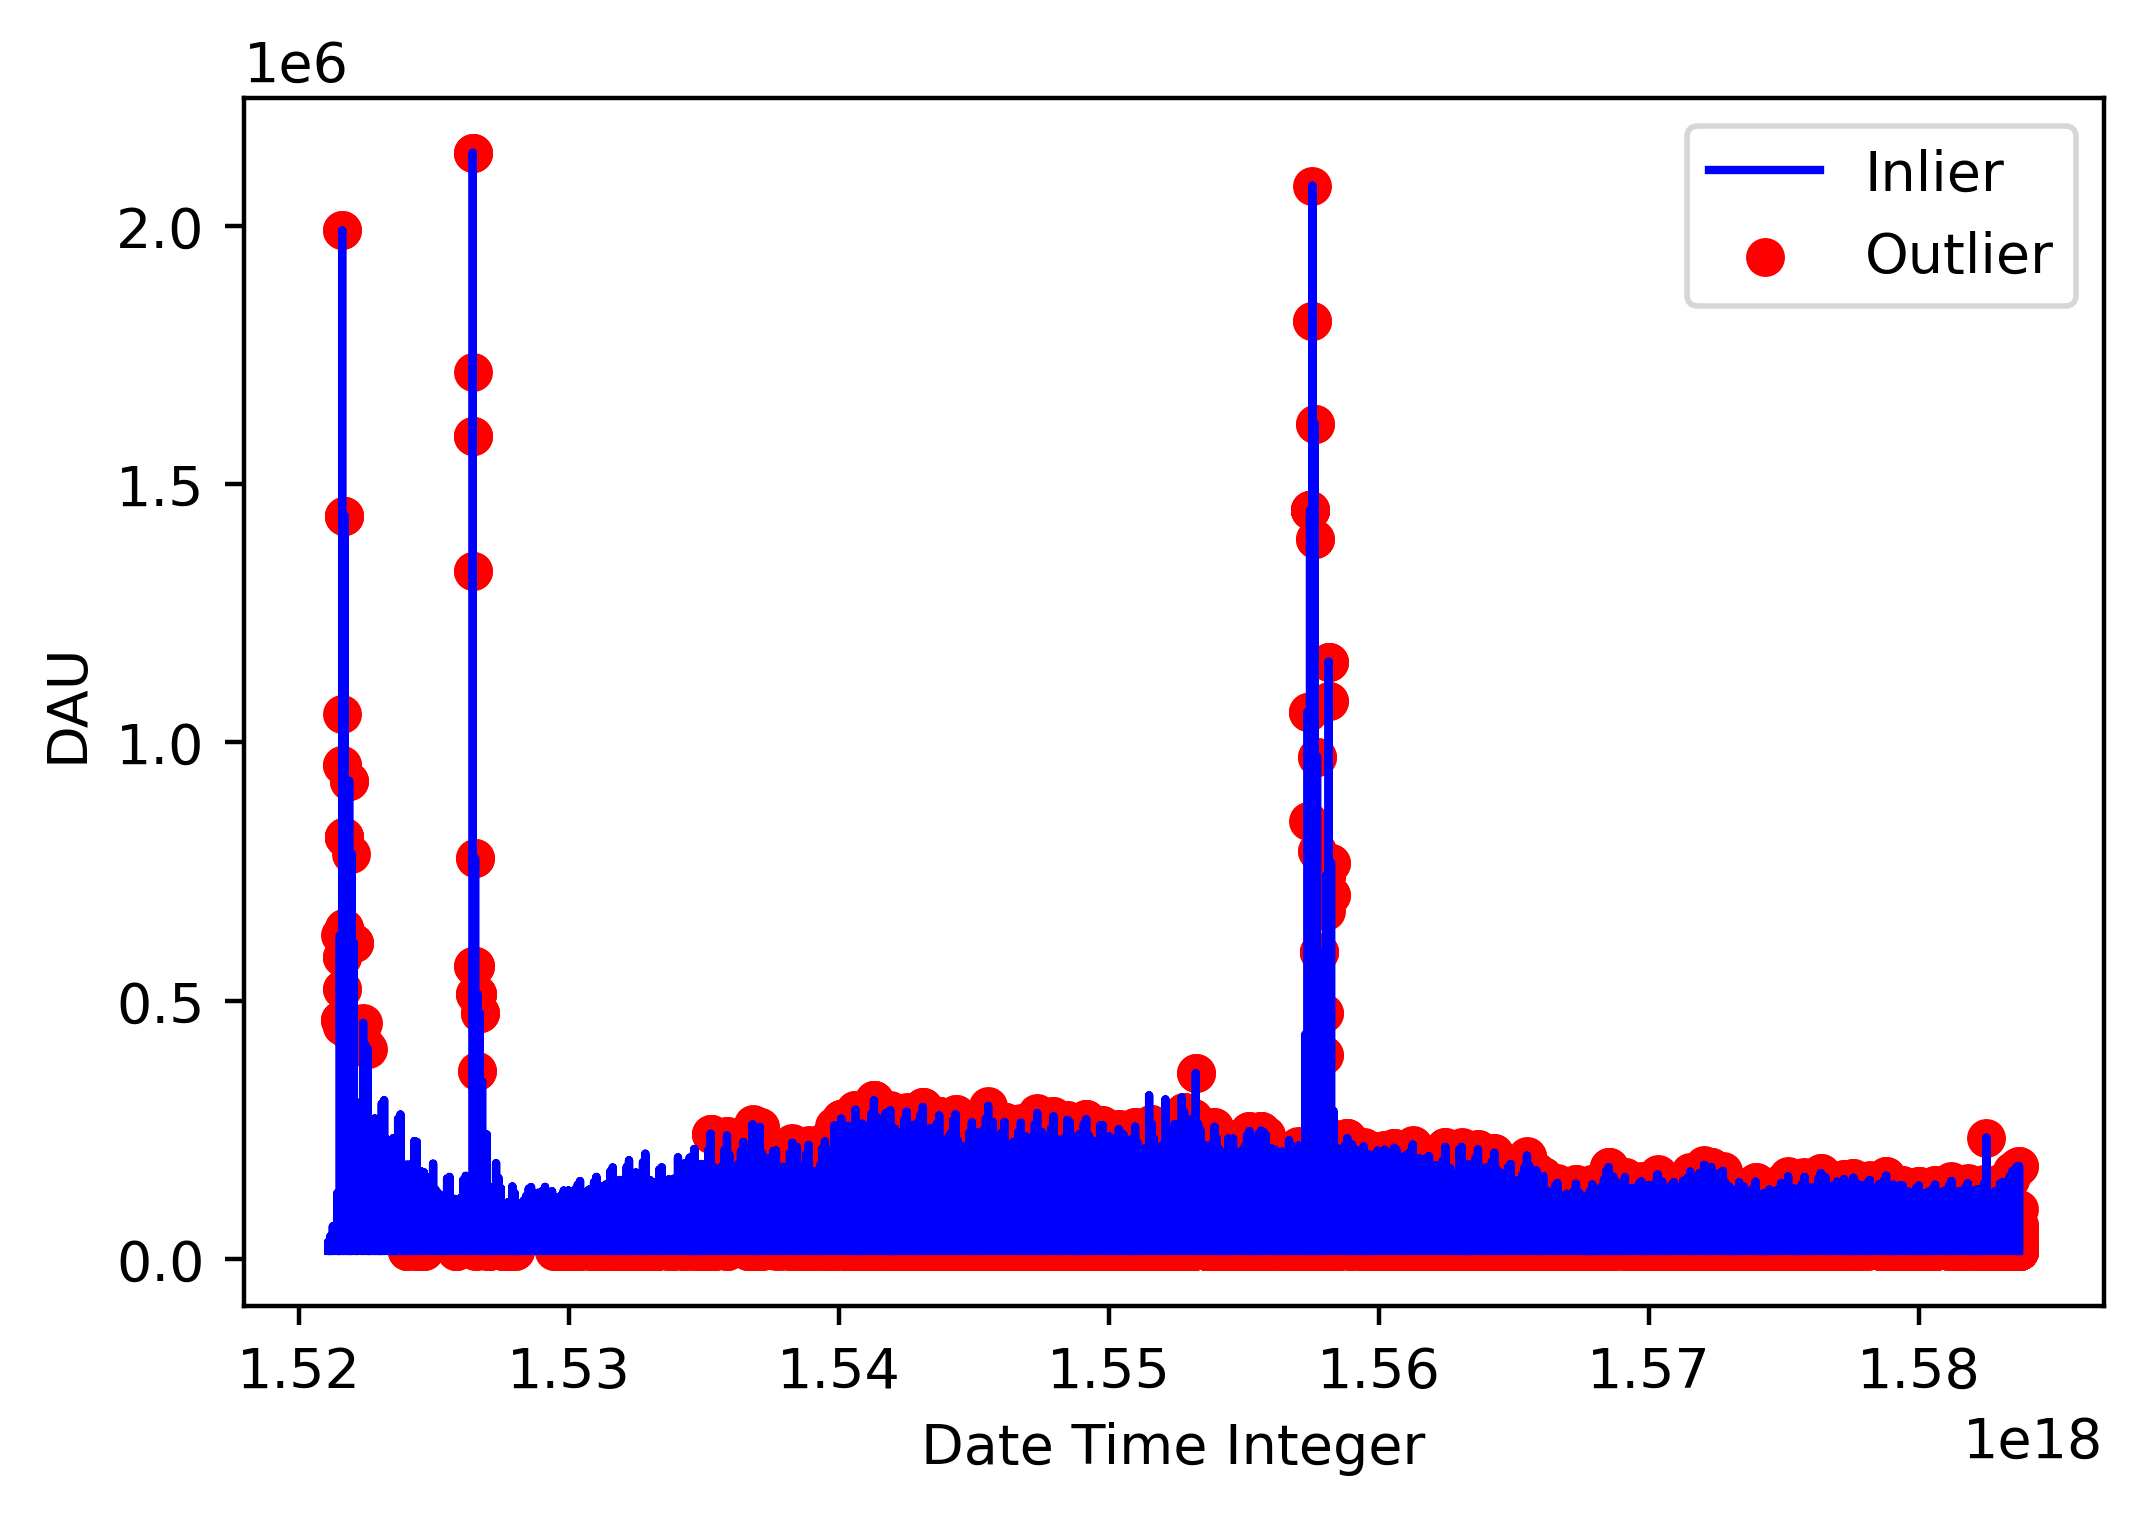

In [293]:
# train isolation forest
AD_IF =  IsolationForest(contamination=contamination, n_jobs=-1)
AD_IF.fit(data_PCA)

# Adding a column marking the outliers detected using isolation forest
df['anomaly_IF'] = pd.Series(AD_IF.predict(data_PCA))

# Visulize the outliers in terms of the metric
metric = 'DAU'
plot_anomaly('anomaly_IF', metric)

### Support Vector Machine

OneclasSVM can be used do identify anomalies with unsupervised learning.

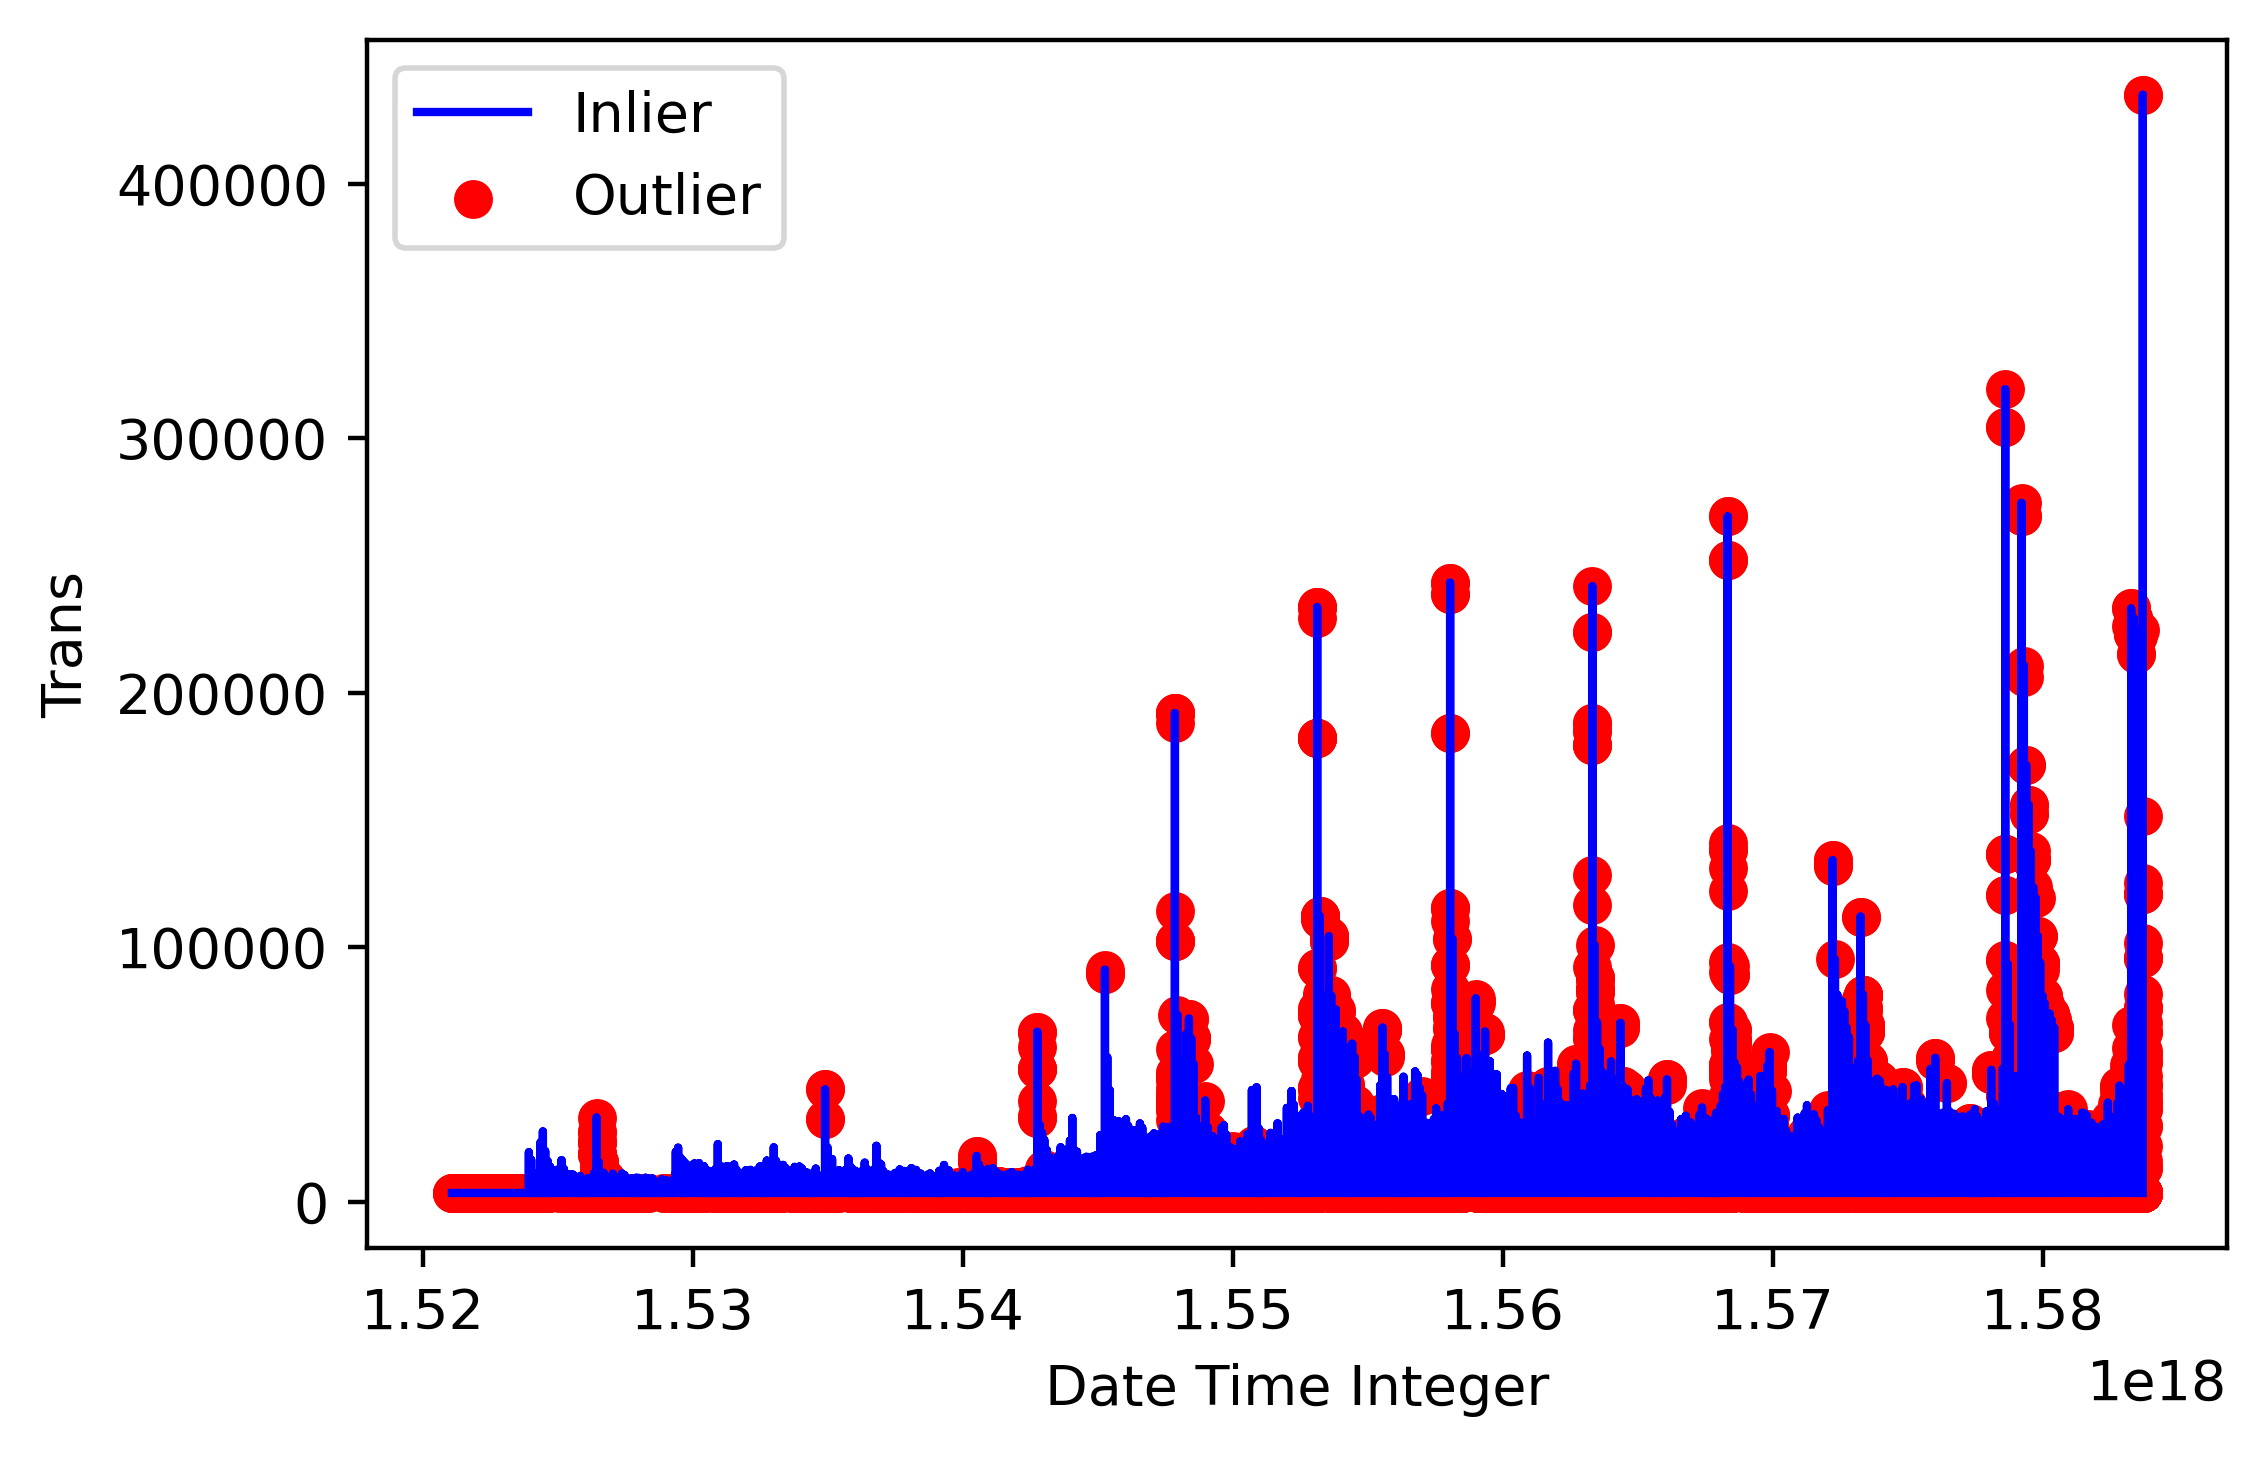

In [237]:
# train Oneclass SVM
AD_SVM = OneClassSVM(nu=contamination, kernel="rbf", gamma=0.01)
AD_SVM.fit(data_PCA)

# Adding a column marking the outliers detected using Oneclass SVM
df['anomaly_SVM'] = pd.Series(AD_SVM.predict(data_PCA))

# Visulize the outliers
metric = 'Trans'
plot_anomaly('anomaly_SVM', metric)

## Summary

There are two clustering models provided:
[`cluster_KMeans`](#KMeans), [`cluster_DBSCAN`](#DBSCAN)
Their predicing cluster of each data is stored in the columns **"cluster_KMeans"** and **"cluster_DBSCAN"** in the DataFrame _`df`_.

There are three anomaly detection results provided in the DataFrame _`df`_:
**"anomaly_KMeans"**, **"anomaly_IF"**, **"anomaly_SVM"**

The first one comes from the clustering model [`cluster_KMeans`](#KMeans-clustering), the sesond one is generated by an Isolation Forest model [`AD_IF`](#Isolation-Forest), and the last one is from a SVM model [`AD_SVM`](#Support-Vector-Mahine).


Since the anomaly detections implemented here are unsupervised learning. After building the models, we have no idea how well it is doing. Hence, the results of those methods need to be tested in the field.